In [1]:
# Import the necessary packages
from imutils import paths
import numpy as np
import imutils
import pickle
import cv2
import os
import model as embedding
import model
from PIL import Image
import torchvision.transforms.functional as TF
import csv
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
# load face detection model
protoPath = "./model_paths/deploy.prototxt.txt"
modelPath = "./model_paths/res10_300x300_ssd_iter_140000.caffemodel"

In [3]:
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load embedding model
embedder = embedding.InceptionResnetV1(pretrained='vggface2').eval()

In [4]:
currentDir = os.getcwd()

dataset = os.path.join(currentDir, "dataset")

datasetCrop = os.path.join(currentDir, "datasetCrop")

embeddingPickle = os.path.join(currentDir, "output/embeddings2.pickle")

# getting all images paths
imagePaths = list(paths.list_images(dataset))

In [14]:
#loop over the image paths
ImgPaths = []
names = []
imageIDs = []
boxs = []
embeddings = []

# initlize the total number of faces processed
total = 0

for (i, imagePath) in enumerate(imagePaths):
    
    #extract the person name from the image path
    
    name = imagePath.split(os.path.sep)[-2]
    imageID = imagePath.split(os.path.sep)[-1].split('.')[-2]
    
    image = cv2.imread(imagePath)
    (h,w) = image.shape[:2]
    
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    detector.setInput(blob)
    detections = detector.forward()
    
    if len(detections) > 0:
        
        # we're making the assumption that each image has only ONE
        # face, so find the bounding box with the largest probalility
        
        i = np.argmax(detections[0, 0, :, 2])
        confidence = detections[0, 0, i, 2]
        
        # ensure that the detection with the largest probability also
        # means our minimum probability test (thus helping filter out
        # weak detections)
        
        if confidence > 0.5:
            
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            
            (startX, startY, endX, endY) = box.astype("int")
            
            face = image[startY:endY , startX:endX]
            (fH , fW) = face.shape[:2]
            
            
            # ensure the facce width and height are sufficently large
            if fW < 20 or fH < 20:
                continue
                
            try:
                faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(160, 160), (0, 0, 0), swapRB=True, crop=False)
            except:
                print("[Error] - Face size in Image not sufficent to get Embeddings : ", imagePath)
                continue
            
            faceTensor = torch.tensor(faceBlob)
            faceEmbed = embedder(faceTensor)
            flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
            
            ImgPaths.append(imagePath)
            imageIDs.append(imageID)
            names.append(name)
            boxs.append(box)
            embeddings.append(flattenEmbed)
            total += 1

# dump the facial embeddings + names to disk
print("[INFO] serializing {} encodings ....".format(total))
data = {"paths":ImgPaths, "names":names, "imageIDs":imageIDs, "boxs":boxs, "embeddings":embeddings}
f = open(embeddingPickle , "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] serializing 56 encodings ....


In [5]:
import pandas as pd

In [6]:
picklefile = pd.read_pickle(embeddingPickle)
df = pd.DataFrame(picklefile)
df.head()

,paths,names,imageIDs,boxs,embeddings
0,/home/prasad/Desktop/facenet/database/dataset/...,dhoni,dhoni-3,"[77.58135738968849, 23.507387459278107, 103.84...","[0.008179506, 0.04155363, -0.061847217, 0.0554..."
1,/home/prasad/Desktop/facenet/database/dataset/...,dhoni,dhoni-1,"[144.21235984563828, 43.6536528468132, 221.701...","[0.007366658, 0.015261916, -0.09058634, -0.017..."
2,/home/prasad/Desktop/facenet/database/dataset/...,dhoni,dhoni-5,"[108.53049084544182, 38.09150987863541, 157.05...","[-0.0135334525, -0.042972263, -0.10696107, -0...."
3,/home/prasad/Desktop/facenet/database/dataset/...,dhoni,dhoni-2,"[103.88608860969543, 16.25392511487007, 141.61...","[0.022095913, 0.034551945, -0.0504368, 0.04939..."
4,/home/prasad/Desktop/facenet/database/dataset/...,dhoni,dhoni-4,"[142.72300165891647, 16.420157834887505, 170.7...","[0.050118376, -0.0050122347, -0.07033947, -0.0..."


## TSNE Visulization

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns

In [18]:
X = np.array(picklefile["embeddings"])
Y = picklefile["names"]
print(X.shape)

(56, 512)


/home/prasad/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


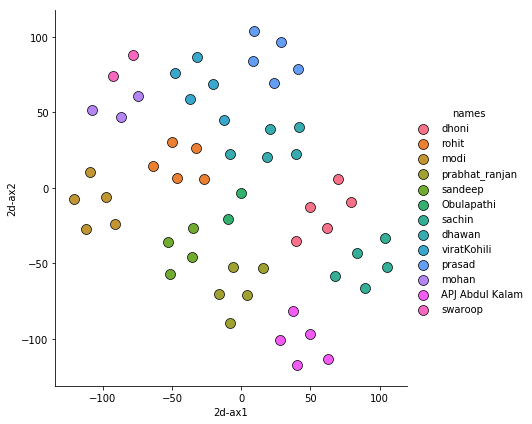

In [19]:
model = TSNE(n_components=2)

tsne_data = model.fit_transform(X)

df["2d-ax1"] = tsne_data[:,0]
df["2d-ax2"] = tsne_data[:,1]

kws = dict(s=100, linewidth=.7, edgecolor="k")
sns.FacetGrid(df, hue="names", size=6).map(plt.scatter, '2d-ax1', '2d-ax2' , **kws).add_legend()

/home/prasad/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


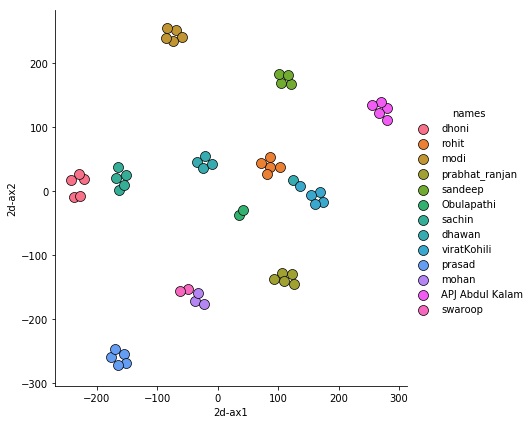

In [20]:
model = TSNE(n_components=2, perplexity=5)

tsne_data = model.fit_transform(X)

df["2d-ax1"] = tsne_data[:,0]
df["2d-ax2"] = tsne_data[:,1]

kws = dict(s=100, linewidth=.7, edgecolor="k")
sns.FacetGrid(df, hue="names", size=6).map(plt.scatter, '2d-ax1', '2d-ax2' , **kws).add_legend()

/home/prasad/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


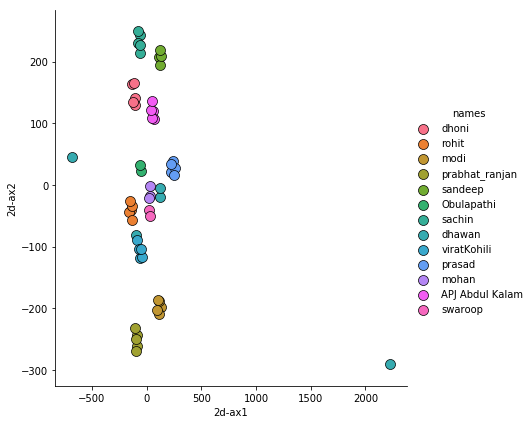

In [21]:
model = TSNE(n_components=2, perplexity=4)

tsne_data = model.fit_transform(X)

df["2d-ax1"] = tsne_data[:,0]
df["2d-ax2"] = tsne_data[:,1]

kws = dict(s=100, linewidth=.7, edgecolor="k")
sns.FacetGrid(df, hue="names", size=6).map(plt.scatter, '2d-ax1', '2d-ax2' , **kws).add_legend()

## ML Models

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [88]:
Embeddings = np.array(picklefile["embeddings"])
Labels = np.array(picklefile["names"])

# labels
le = LabelEncoder()
labels = le.fit_transform(Labels)

X_train, X_test, y_train, y_test = train_test_split(Embeddings, labels, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(44, 512)
(12, 512)
(44,)
(12,)


In [89]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [90]:
set(y_test)

{2, 3, 4, 7, 8, 9, 10, 12}

In [98]:
knn = KNeighborsClassifier(n_neighbors=1 , metric='euclidean', weights="distance")
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn * 100}, SVM accuracy = {acc_svc * 100}')

KNN accuracy = 100.0, SVM accuracy = 100.0


## Distance (Best threshold for the verification)

In [101]:
Embeddings = np.array(picklefile["embeddings"])
Labels = labels

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

/home/prasad/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


##### Best threshold =  0.74
##### Best F1-Score =  0.9269311064718163
##### Best Accurecy =  0.9884297520661157


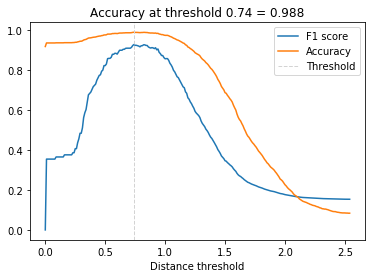

In [149]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # L2 distance
identical = [] #1 if same identity, 0 otherwise

num = len(Embeddings)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(Embeddings[i], Embeddings[j]))
        identical.append(1 if labels[i] == labels[j] else 0)
        
distances = np.array(distances)
identical = np.array(identical)

minDist = min(distances)
maxDist = max(distances)

thresholds = np.arange(minDist, maxDist, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
#Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal accurecy
opt_acc = accuracy_score(identical, distances < opt_tau)

print("##### Best threshold = ", opt_tau)
print("##### Best F1-Score = ", f1_scores[opt_idx])
print("##### Best Accurecy = ", opt_acc)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();


## Distance distributions of positive and negative pairs

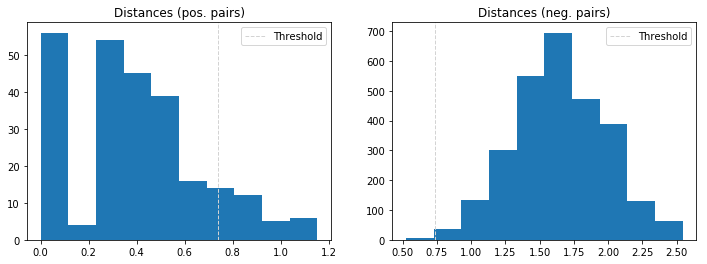

In [150]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

## Train a model

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle
import numpy as np

In [54]:
embeddingPickle = os.path.join(currentDir, "output/embeddings2.pickle")

recognizerPickle = "./output/recognizer2.pickle"

lebelPickle = "./output/labelPickle2.pickle"

data = pickle.loads(open(embeddingPickle, "rb").read())

# encode the labels
le = LabelEncoder()
labels = le.fit_transform(data["names"])

#Embeddings
Embeddings = np.array(data["embeddings"])

# train the model used to accept the 512-d embeddings of the face and 
# then produce the actual face recognition

#recognizer = KNeighborsClassifier(n_neighbors= 2, metric='euclidean', weights="distance")
recognizer = SVC(probability=True)
recognizer.fit(Embeddings, labels)

# write the actual face recognition model to disk
f = open(recognizerPickle, "wb")
f.write(pickle.dumps(recognizer))
f.close()

# write the label encoder to disk
f = open(lebelPickle,"wb")
f.write(pickle.dumps(le))
f.close()

/home/prasad/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Recognize

In [2]:
import numpy as np
import imutils
import pickle
import cv2
import os
import model as embedding
from imutils import paths
from PIL import Image

In [3]:
imagePath = "khili-sachin-dhoni.jpg"

In [6]:
# load face detectection model

protoPath = "./model_paths/deploy.prototxt.txt"
modelPath = "./model_paths/res10_300x300_ssd_iter_140000.caffemodel"

recognizerPickle = "./output/SimpleRecognizer.pickle"
labelPickle = "./output/SimpleLabel.pickle"

predictedImg = "./predictedImg"

In [7]:
# loading face detection model
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load embedding model
embedder = embedding.InceptionResnetV1(pretrained="vggface2").eval()

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(recognizerPickle, "rb").read())
label = pickle.loads(open(labelPickle, "rb").read())

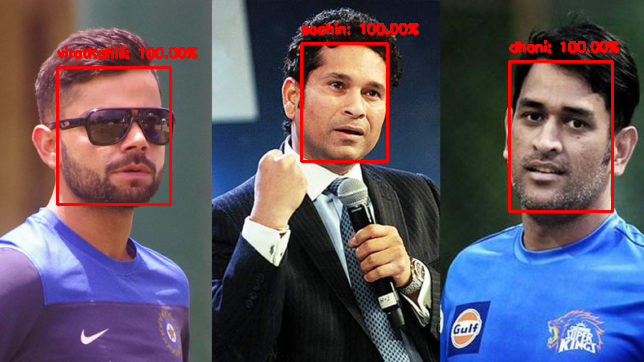

In [8]:
image = cv2.imread(imagePath)
(h,w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

detector.setInput(blob)
detections = detector.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
    
    # extract the confidence (i.e., probalility) associated with the prediction
    confidence = detections[0, 0, i, 2]
    
    # fillter out weak detections
    if confidence > 0.2:
        
        # compute the (x ,y) - coordinates of the bounding box for the face
        
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        
        # extract the face ROI
        face = image[startY:endY , startX:endX]
        (fH ,fW) = face.shape[:2]
        
        # ensure the facce width and height are sufficently large
        if fW < 20 or fH < 20:
            print("[Error] - Face size in Image not sufficent to get Embeddings : ", imagePath)
            continue
        try:
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(160, 160), (0, 0, 0), swapRB=True, crop=False)
        except:
            print("[Error] - Face size in Image not sufficent to get Embeddings : ", imagePath)
            continue
        
        faceTensor = torch.tensor(faceBlob)
        faceEmbed = embedder(faceTensor)
        flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
        
        array = np.array(flattenEmbed).reshape(1,-1)
        
        # perform classification to recognize the face
        
        preds = recognizer.predict_proba(array)[0]
        
        j = np.argmax(preds)
        
        proba = preds[j]
        name = label.classes_[j]
        
        #draw the bunding box of the face along with the associated probability
        
        text = "{}: {:.2f}%".format(name, proba * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
        
        cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        
# save image predicte foler
cv2.imwrite("{}/{}.png".format(predictedImg, name), image)
im = Image.open("{}/{}.png".format(predictedImg, name))
im